### MicroKPNN_encoder_confounder_free

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shap
import torch

# Ensure the SHAP plots display inline in Jupyter Notebook
%matplotlib inline
def format_species_name(name):
    """
    Replace underscores with spaces in the species names.
    """
    
    return name.replace("_", " ")

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)
    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]


def get_data(file_path, metadata_file_path):
    """
    Load and merge metadata and relative abundance data for training.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Paths to data and model files
train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path = "MetaCardis_data/train_T2D_metadata.csv"
feature_columns_path = "old_Results/MicroKPNN_encoder_confounder_free_plots/feature_columns.csv"

# Load merged data
merged_data = get_data(train_abundance_path, train_metadata_path)

# Define feature columns
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

# Load the species ID mapping
species_ids_path = "Default_Database/species_ids.csv"
species_df = pd.read_csv(species_ids_path)

# Create a mapping from taxon_id to species name
taxon_to_species = dict(zip(species_df['taxon_id'].astype(str), species_df['species']))

# Replace taxon IDs with species names in feature_columns
feature_columns_with_species = [
    format_species_name(taxon_to_species.get(taxon_id, taxon_id)) for taxon_id in feature_columns
]



X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# List to store SHAP values from each fold
shap_values_list = []

# Load SHAP values from each fold
for fold in range(1, 6):
    shap_df = pd.read_csv(f"old_Results/MicroKPNN_encoder_confounder_free_plots/shap_values_fold{fold}.csv")
    shap_values_list.append(shap_df.values)

# Convert the list to a NumPy array and calculate the average
shap_values_avg = np.mean(shap_values_list, axis=0)

# Save the averaged SHAP values
avg_shap_df = pd.DataFrame(shap_values_avg, columns=feature_columns)
avg_shap_df.to_csv("old_Results/MicroKPNN_encoder_confounder_free_plots/avg_shap_values.csv", index=False)

# Save SHAP summary bar plot
shap.summary_plot(
    shap_values_avg, 
    X, 
    feature_names=feature_columns_with_species, 
    plot_type="bar", 
    show=False
)
plt.savefig("old_Results/MicroKPNN_encoder_confounder_free_plots/shap_summary_bar_plot.png", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot

# Save SHAP summary plot
shap.summary_plot(
    shap_values_avg, 
    X, 
    feature_names=feature_columns_with_species, 
    show=False
)
plt.xlabel("SHAP Value (impact on model output)", fontsize=18)  # Increase x-axis label font size
plt.ylabel("Species", fontsize=18)  #
plt.xticks(fontsize=16)  # Adjust x-axis tick font size
# Get the current y-axis tick labels and set them italic
current_yticks = plt.gca().get_yticks()
current_yticklabels = plt.gca().get_yticklabels()
italic_labels = [
    "$\\mathit{" + label.get_text().replace(" ", "\\ ") + "}$" for label in current_yticklabels
]  # LaTeX style with spaces preserved
plt.gca().set_yticks(current_yticks)
plt.gca().set_yticklabels(italic_labels, fontsize=16)
plt.savefig("old_Results/MicroKPNN_encoder_confounder_free_plots/shap_summary_plot.pdf", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot

# # Display SHAP summary plot in the Jupyter notebook
# shap.summary_plot(shap_values_avg, X, feature_names=feature_columns, plot_type="bar")
# shap.summary_plot(shap_values_avg, X, feature_names=feature_columns)
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values_avg).mean(axis=0)

# Create a DataFrame for feature names and their mean SHAP values
shap_feature_importance = pd.DataFrame({
    "Feature": feature_columns_with_species,
    "Mean_ABS_SHAP_Value": mean_abs_shap_values
})

# Sort features by their SHAP importance in descending order
top_features = shap_feature_importance.sort_values(by="Mean_ABS_SHAP_Value", ascending=False).head(20)

# Print the top 20 features as a list
print("Top 20 Features based on SHAP values:")
print(top_features["Feature"].tolist())



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Top 20 Features based on SHAP values:
['Escherichia coli', 'Acidaminococcus fermentans', 'Holdemania filiformis', 'Lactococcus lactis', 'Clostridium bolteae', 'Butyrivibrio crossotus', 'Methanosphaera stadtmanae', 'Acidaminococcus intestini', 'Streptococcus mutans', 'Bacteroides thetaiotaomicron', 'Bifidobacterium bifidum', 'Sutterella wadsworthensis', 'Phascolarctobacterium succinatutens', 'Bacteroides fragilis', 'Capnocytophaga sp  oral taxon 329', 'Haemophilus parainfluenzae', 'Lactobacillus sakei', 'Anaerotruncus colihominis', 'Methanobrevibacter smithii', 'Escherichia albertii']


#### First layer

X shape: (671, 371)
Mask shape: torch.Size([415, 371])

=== Loading model fold 1: old_Results/MicroKPNN_encoder_confounder_free_plots/trained_model1.pth ===

=== Loading model fold 2: old_Results/MicroKPNN_encoder_confounder_free_plots/trained_model2.pth ===


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl


=== Loading model fold 3: old_Results/MicroKPNN_encoder_confounder_free_plots/trained_model3.pth ===

=== Loading model fold 4: old_Results/MicroKPNN_encoder_confounder_free_plots/trained_model4.pth ===

=== Loading model fold 5: old_Results/MicroKPNN_encoder_confounder_free_plots/trained_model5.pth ===
hidden_avg shape: (671, 415)
shap_avg shape: (671, 415)
Saved averaged hidden activations and SHAP values to CSV.
{'0': '0', '1': '1', '2': '10', '3': '11', '4': '12', '5': '12-EthanediolEthyleneglycolProductionexport', '6': '12-propanediolPropenediolPropyleneglycolR-12-propanediolR-propane-12-diolS-12-propanediolS-propane-12-diolConsumptionimport', '7': '12-propanediolPropenediolPropyleneglycolR-12-propanediolR-propane-12-diolS-12-propanediolS-propane-12-diolProductionexport', '8': '13', '9': '13-PropanediolProductionexport', '10': '14', '11': '147', '12': '148', '13': '153', '14': '16', '15': '17', '16': '18', '17': '182', '18': '19', '19': '2', '20': '2-OxobutyrateAlpha-ketobutyrate

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


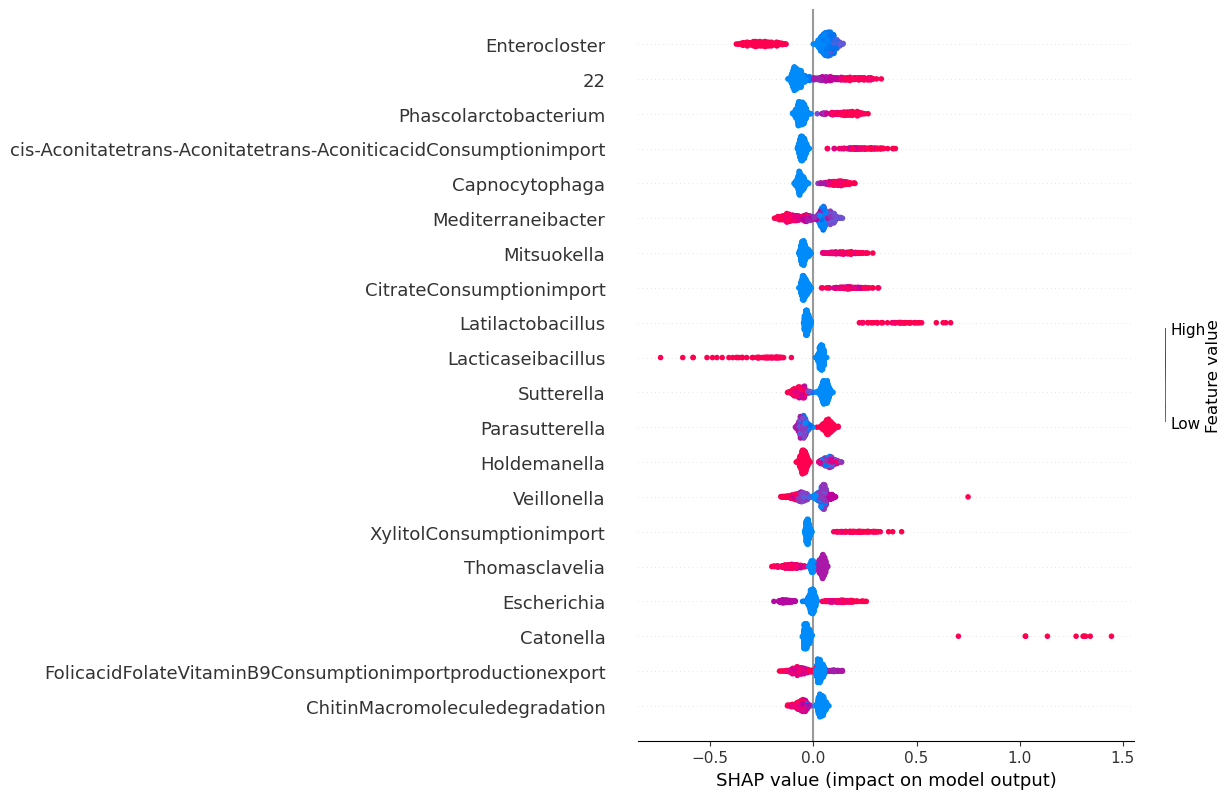

Done! Displayed bar + swarm summary for the averaged first-layer SHAP.


In [19]:
##########################################
# JUPYTER NOTEBOOK CELL 1: Imports 
# First layer (knowledge pimre layer)
##########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import torch

# If you're in a Jupyter environment, ensure inline plotting:
%matplotlib inline

##########################################
# JUPYTER NOTEBOOK CELL 2: Build Mask
##########################################
def build_mask(edge_list, species):
    # generate the mask
    edge_df = pd.read_csv(edge_list)
    
    edge_df['parent'] = edge_df['parent'].astype(str)
    parent_nodes = sorted(set(edge_df['parent'].tolist()))  # Sort to ensure consistent order
    mask = torch.zeros(len(species), len(parent_nodes))
    child_nodes = species

    parent_dict = {k: i for i, k in enumerate(parent_nodes)}
    child_dict = {k: i for i, k in enumerate(child_nodes)}
    
    for i, row in edge_df.iterrows():
        if row['child'] != 'Unnamed: 0': 
            mask[child_dict[str(row['child'])]][parent_dict[row['parent']]] = 1

    return mask.T

##########################################
# JUPYTER NOTEBOOK CELL 3: Data loading
##########################################
def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, 
    and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values

    # Example transformations
    X_log = np.log(X + 1)

    # Optionally standard-scale
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)

    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def get_data(file_path, metadata_file_path):
    """
    Merge metadata and transformed abundance data by SampleID.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')
    return merged_data

##########################################
# JUPYTER NOTEBOOK CELL 4: Model & Helpers
##########################################
# We'll import or define your GAN model with the MaskedLinear
from MicroKPNN_encoder_confounder_free_lib.models import *  # Make sure models.py is in your path, or paste the definition

def get_first_hidden_activations(model, x):
    """
    Forward pass x through the first hidden layer:
      - encoder[0]: MaskedLinear
      - encoder[1]: BatchNorm
      - encoder[2]: ReLU
    Return shape: [batch_size, hidden_dim_of_first_layer]
    """
    out = model.encoder[0](x)
    out = model.encoder[1](out)
    out = model.encoder[2](out)
    return out

##########################################
# JUPYTER NOTEBOOK CELL 5: Set Up Paths
##########################################

train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path   = "MetaCardis_data/train_T2D_metadata.csv"
edge_list_path        = "Default_Database/EdgeList.csv"
model_prefix          = "old_Results/MicroKPNN_encoder_confounder_free_plots/trained_model"
shap_csv_prefix       = "old_Results/MicroKPNN_encoder_confounder_free_plots/shap_values_first_hidden_fold"

feature_columns_path  = "old_Results/MicroKPNN_encoder_confounder_free_plots/feature_columns.csv"

num_folds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# JUPYTER NOTEBOOK CELL 6: Load Data + Mask
##########################################
merged_data = get_data(train_abundance_path, train_metadata_path)

# 1) Figure out the "feature columns" to keep
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns  = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

# 2) Build X
X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
print("X shape:", X.shape)

# 3) Build the mask
#    We read the original abundance CSV (untransformed) for 'species' if needed:
raw_abundance_df = pd.read_csv(train_abundance_path, index_col=0)
species = raw_abundance_df.columns.values.tolist()

mask = build_mask(edge_list_path, species)
print("Mask shape:", mask.shape)

##########################################
# JUPYTER NOTEBOOK CELL 7: Collect SHAP + Activations
##########################################
hidden_list = []
shap_list   = []
node_names  = None

for fold in range(1, num_folds + 1):
    # 1) Load model
    model_path = f"{model_prefix}{fold}.pth"
    print(f"\n=== Loading model fold {fold}: {model_path} ===")

    base_model = GAN(mask=mask).to(device)
    state_dict = torch.load(model_path, map_location=device)
    base_model.load_state_dict(state_dict)
    base_model.eval()

    # 2) Forward pass => first hidden-layer
    with torch.no_grad():
        hidden_activations = get_first_hidden_activations(base_model, X_tensor)
    hidden_activations_np = hidden_activations.cpu().numpy()
    hidden_list.append(hidden_activations_np)

    # 3) Load SHAP for fold => shape [N, d_hidden]
    shap_csv_path = f"{shap_csv_prefix}{fold}.csv"
    shap_df = pd.read_csv(shap_csv_path)
    shap_values_np = shap_df.values
    shap_list.append(shap_values_np)

    # Save column names if first time
    if node_names is None:
        node_names = shap_df.columns.tolist()

##########################################
# JUPYTER NOTEBOOK CELL 8: Average Over Folds
##########################################
# Stack => shape (num_folds, N, d_hidden)
hidden_array = np.stack(hidden_list, axis=0)  # [5, N, d_hidden]
shap_array   = np.stack(shap_list, axis=0)    # [5, N, d_hidden]

hidden_avg = hidden_array.mean(axis=0)        # [N, d_hidden]
shap_avg   = shap_array.mean(axis=0)          # [N, d_hidden]

print("hidden_avg shape:", hidden_avg.shape)
print("shap_avg shape:",   shap_avg.shape)

##########################################
# JUPYTER NOTEBOOK CELL 9: (Optional) Save Averages
##########################################
avg_hidden_df = pd.DataFrame(hidden_avg, columns=node_names)
avg_hidden_df.to_csv("old_Results/MicroKPNN_encoder_confounder_free_plots/avg_hidden_activations_first_layer.csv", index=False)

avg_shap_df = pd.DataFrame(shap_avg, columns=node_names)
avg_shap_df.to_csv("old_Results/MicroKPNN_encoder_confounder_free_plots/avg_shap_values_first_layer.csv", index=False)

print("Saved averaged hidden activations and SHAP values to CSV.")


parent_dict_path = "old_Results/MicroKPNN_encoder_confounder_free_plots/parent_dict.csv"
parents_df = pd.read_csv(parent_dict_path)

# Create a mapping from taxon_id to species name
id_to_names = dict(zip(parents_df['value'].astype(str), parents_df['key']))
print(id_to_names)

# Replace taxon IDs with species names in feature_columns
hidden_columns_with_names = [
    id_to_names.get(node.replace("Node_", ""), node) for node in node_names
]

print(node_names)

print(hidden_columns_with_names)

##########################################
# JUPYTER NOTEBOOK CELL 10: Final SHAP Plots
##########################################
plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_avg,       # shape [N, d_hidden], the SHAP values
    hidden_avg,     # shape [N, d_hidden], the actual hidden activations
    feature_names=hidden_columns_with_names,
    plot_type="bar",
    show = False
)
plt.savefig("old_Results/MicroKPNN_encoder_confounder_free_plots/shap_summary_plot_hidden.png", dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_avg,
    hidden_avg,
    feature_names=hidden_columns_with_names,
    plot_type="dot"
)

plt.show()

print("Done! Displayed bar + swarm summary for the averaged first-layer SHAP.")
